In [9]:
import pandas as pd
import numpy as np
import LSTM_preprocessing as pre
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mysql.connector
from mysql.connector import Error
import warnings
warnings.filterwarnings("ignore")

In [7]:
connection = pre.connect_to_database()

if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())

    else:
        print("\nNo data found after merging.")

    # Close the connection
    pre.query_quit(connection)

Connected to MySQL database, MySQL Server version:  8.0.39

Merged DataFrame:
   id crypto_symbol                date lending_rate borrowing_rate  \
0   1       BATUSDT 2020-12-02 14:00:00   -50.000000     -50.000000   
1   2       BATUSDT 2020-12-02 15:00:00   -50.000000     -50.000000   
2   3       BATUSDT 2020-12-02 16:00:00   -50.000000     -50.000000   
3   4       BATUSDT 2020-12-02 17:00:00   -50.000000     -50.000000   
4   5       BATUSDT 2020-12-02 18:00:00   -50.000000     -50.000000   

  utilization_rate stable_borrow_rate crypto_symbol                date  high  \
0       -50.000000           0.030000       BATUSDT 2020-12-02 14:00:00  0.24   
1       -50.000000           0.030000       BATUSDT 2020-12-02 15:00:00  0.24   
2         0.013598           0.030000       BATUSDT 2020-12-02 16:00:00  0.24   
3         0.014834           0.030000       BATUSDT 2020-12-02 17:00:00  0.24   
4         0.014834           0.030000       BATUSDT 2020-12-02 18:00:00  0.25   

    low 

In [8]:
# Drop the second occurrence of a specific column
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# data without NA rows if we needed 
filtered_df = merged_df[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df.reset_index(inplace=True, drop=True)
# date formatting
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
# taking the columns we want and converting them to floats
filtered_df = filtered_df[['crypto_symbol', 'date', 'lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']]
filtered_df[['lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)


In [24]:
# Initialize empty lists to store aggregated inputs and targets
all_inputs = []
all_targets = []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
s = symbols[0]

sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
sim_df.reset_index(inplace=True, drop=True)
print(s, len(sim_df))
# First Loop: Calculate intervals for each column without modifying the DataFrame
intervals = {}
for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
     lower, upper = pre.calculate_iqr_bounds(sim_df[column])
     intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

# getting the returns
reduced_df = sim_df.copy()
reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
reduced_df = reduced_df[reduced_df['returns'].notna()]
print('rows with valid returns:', len(reduced_df))
reduced_df.reset_index(inplace=True, drop=True)

# Second Loop: Filter rows based on the pre-calculated intervals
for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
     lower_bound = intervals[column]['lower_bound']
     upper_bound = intervals[column]['upper_bound']
     # Apply filtering based on pre-calculated bounds
     reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

reduced_df.reset_index(inplace=True, drop=True)

# MinMax scaling
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

scaled_df = reduced_df.copy()
scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

inputs, targets = pre.extract_valid_windows(
     scaled_df,
     'date', 
     48, 24, 
     ['lending_rate',	'borrowing_rate','utilization_rate','returns', 'volume'], 
     ['lending_rate','borrowing_rate']
     )


print('input size', inputs.shape)
print('output size', targets.shape)

# Count NaNs in input and output
input_nans = np.isnan(inputs).sum()
output_nans = np.isnan(targets).sum()

print(f"Number of NaNs in input: {input_nans}")
print(f"Number of NaNs in output: {output_nans}")


BATUSDT 28159
rows with valid returns: 27850
input size (10222, 48, 5)
output size (10222, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0


In [32]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


# 3. establish the 
model = Sequential([
    LSTM(48, activation='tanh', input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(48, activation='tanh'),
    Dropout(0.2),
    Dense(targets.shape[1] * targets.shape[2]), 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=20, batch_size=32, validation_split=0.2)

# 5. validate the model
test_loss, test_mae = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1))
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# 6. calculate predictions
predictions = model.predict(X_test)





(8177, 48, 5)
(2045, 48, 5)
(8177, 24, 2)
(2045, 24, 2)
Epoch 1/20


205/205 [==============================] - 11s 35ms/step - loss: 0.0122 - mae: 0.0663 - val_loss: 0.0024 - val_mae: 0.0240
Epoch 2/20
205/205 [==============================] - 7s 32ms/step - loss: 0.0045 - mae: 0.0388 - val_loss: 0.0022 - val_mae: 0.0195
Epoch 3/20
205/205 [==============================] - 6s 32ms/step - loss: 0.0037 - mae: 0.0328 - val_loss: 0.0020 - val_mae: 0.0206
Epoch 4/20
205/205 [==============================] - 7s 33ms/step - loss: 0.0033 - mae: 0.0301 - val_loss: 0.0019 - val_mae: 0.0186
Epoch 5/20
205/205 [==============================] - 7s 33ms/step - loss: 0.0030 - mae: 0.0280 - val_loss: 0.0018 - val_mae: 0.0206
Epoch 6/20
205/205 [==============================] - 7s 33ms/step - loss: 0.0028 - mae: 0.0261 - val_loss: 0.0015 - val_mae: 0.0152
Epoch 7/20
205/205 [==============================] - 7s 34ms/step - loss: 0.0026 - mae: 0.0245 - val_loss: 0.0016 - val_mae: 0.0190
Epoch 8/20

In [ ]:
predictions.shape

(2045, 48)

In [ ]:
# Split into two separate outputs
# lending_rate
output_1 = targets[:, :, 0].reshape(targets.shape[0], targets.shape[1], 1)  # First column
# borrowing rate
output_2 = targets[:, :, 1].reshape(targets.shape[0], targets.shape[1], 1)  # Second column
# lets predict seperatly


(8177, 48, 5)
(2045, 48, 5)
(8177, 24, 1)
(2045, 24, 1)
Epoch 1/10
66/66 [==============================] - 7s 59ms/step - loss: 0.0292 - mae: 0.1098 - val_loss: 0.0041 - val_mae: 0.0323
Epoch 2/10
66/66 [==============================] - 3s 45ms/step - loss: 0.0089 - mae: 0.0572 - val_loss: 0.0036 - val_mae: 0.0299
Epoch 3/10
66/66 [==============================] - 3s 48ms/step - loss: 0.0073 - mae: 0.0493 - val_loss: 0.0033 - val_mae: 0.0247
Epoch 4/10
66/66 [==============================] - 3s 46ms/step - loss: 0.0064 - mae: 0.0451 - val_loss: 0.0036 - val_mae: 0.0294
Epoch 5/10
66/66 [==============================] - 3s 49ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0032 - val_mae: 0.0265
Epoch 6/10
66/66 [==============================] - 3s 49ms/step - loss: 0.0055 - mae: 0.0402 - val_loss: 0.0040 - val_mae: 0.0356
Epoch 7/10
66/66 [==============================] - 3s 48ms/step - loss: 0.0052 - mae: 0.0390 - val_loss: 0.0030 - val_mae: 0.0231
Epoch 8/10
66/66 [=========

Training data shape: (6132, 48, 5)
Validation data shape: (2045, 48, 5)
Test data shape: (2045, 48, 5)
Training labels shape: (6132, 24, 1)
Validation labels shape: (2045, 24, 1)
Test labels shape: (2045, 24, 1)
Epoch 1/10
62/62 [==============================] - 7s 60ms/step - loss: 0.0251 - mae: 0.1047 - val_loss: 0.0041 - val_mae: 0.0366
Epoch 2/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0086 - mae: 0.0561 - val_loss: 0.0033 - val_mae: 0.0270
Epoch 3/10
62/62 [==============================] - 3s 47ms/step - loss: 0.0071 - mae: 0.0486 - val_loss: 0.0032 - val_mae: 0.0255
Epoch 4/10
62/62 [==============================] - 3s 45ms/step - loss: 0.0065 - mae: 0.0457 - val_loss: 0.0031 - val_mae: 0.0245
Epoch 5/10
62/62 [==============================] - 3s 44ms/step - loss: 0.0058 - mae: 0.0418 - val_loss: 0.0031 - val_mae: 0.0274
Epoch 6/10
62/62 [==============================] - 3s 46ms/step - loss: 0.0055 - mae: 0.0395 - val_loss: 0.0030 - val_mae: 0.0260
Ep

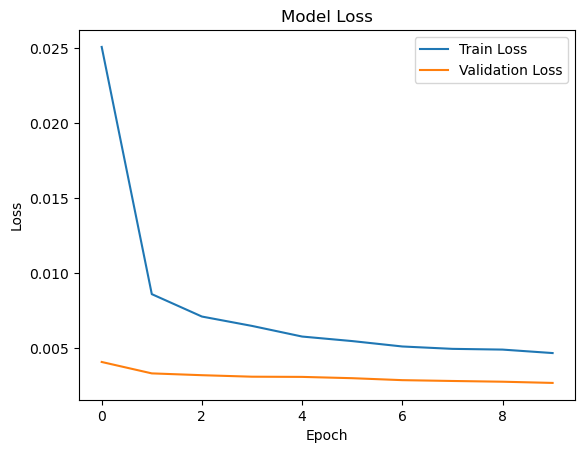

64/64 [==============================] - 2s 11ms/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def train_and_evaluate(inputs, outputs, test_size=0.2, valid_size=0.25, random_state=42, epochs=30, batch_size=100):
    # Clearing the TensorFlow session to ensure the model starts with fresh weights and biases
    tf.keras.backend.clear_session()

    # Setting the seed for reproducibility
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # Splitting the data into train+validation and test sets
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        inputs, outputs, test_size=test_size, random_state=random_state)

    # Splitting the train+validation set into separate training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_valid, y_train_valid, test_size=valid_size, random_state=random_state)

    # Printing the shapes of the datasets
    print("Training data shape:", X_train.shape)
    print("Validation data shape:", X_valid.shape)
    print("Test data shape:", X_test.shape)
    print("Training labels shape:", y_train.shape)
    print("Validation labels shape:", y_valid.shape)
    print("Test labels shape:", y_test.shape)

    # Model definition
    model = Sequential([
        LSTM(48, activation='tanh', input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(48, activation='tanh'),
        Dropout(0.2),
        Dense(outputs.shape[1] * outputs.shape[2]),
    ])

    # Compiling the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training the model
    history = model.fit(
        X_train, y_train.reshape(y_train.shape[0], -1),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid.reshape(y_valid.shape[0], -1))
    )

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Making predictions on the test set
    test_predictions = model.predict(X_test)
    return y_test, test_predictions


y_test, test_predictions = train_and_evaluate(inputs, output_1)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


def rate_growth(data, prediction, threshold_factor=0.1):
    # Calculate changes for data
    changes_data = data[:, 23, 0] - data[:, 0, 0]
    std_data = np.std(changes_data)
    threshold_data = threshold_factor * std_data

    # Classify growth for data
    growth_data = []
    for change in changes_data:
        if change > threshold_data:
            growth_data.append(1)
        elif change < -threshold_data:
            growth_data.append(-1)
        else:
            growth_data.append(0)

    # Calculate changes for prediction
    changes_prediction = prediction[:, 23] - prediction[:, 0]
    std_prediction = np.std(changes_prediction)
    threshold_prediction = threshold_factor * std_prediction

    # Classify growth for prediction
    growth_prediction = []
    for change in changes_prediction:
        if change > threshold_prediction:
            growth_prediction.append(1)
        elif change < -threshold_prediction:
            growth_prediction.append(-1)
        else:
            growth_prediction.append(0)

    return growth_data, growth_prediction

def classification_metrics(y_true, y_pred):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Visualization of the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Printing classification metrics
    print("Classification Metrics:")
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['-1', '0', '1']))

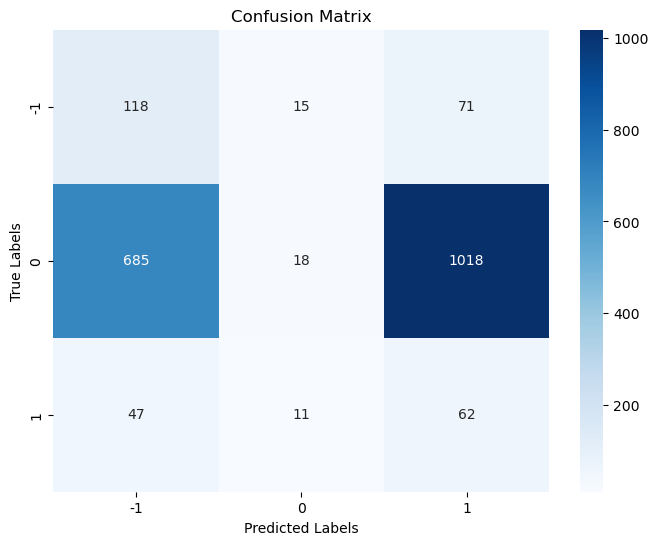

Classification Metrics:
Accuracy: 0.10
Precision: 0.20
Recall: 0.37
F1 Score: 0.11

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.58      0.22       204
           0       0.41      0.01      0.02      1721
           1       0.05      0.52      0.10       120

    accuracy                           0.10      2045
   macro avg       0.20      0.37      0.11      2045
weighted avg       0.36      0.10      0.05      2045



In [94]:
growth_data, growth_prediction = rate_growth(y_test, test_predictions)
classification_metrics(growth_data, growth_prediction)

BATUSDT 28159
rows with valid returns: 27850
input size (10222, 48, 5)
output size (10222, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and BATUSDT
Training data shape: (6132, 48, 5)
Validation data shape: (2045, 48, 5)
Test data shape: (2045, 48, 5)
Training labels shape: (6132, 24, 1)
Validation labels shape: (2045, 24, 1)
Test labels shape: (2045, 24, 1)
Epoch 1/10
62/62 [==============================] - 7s 59ms/step - loss: 0.0324 - mae: 0.1167 - val_loss: 0.0044 - val_mae: 0.0393
Epoch 2/10
62/62 [==============================] - 3s 47ms/step - loss: 0.0098 - mae: 0.0597 - val_loss: 0.0034 - val_mae: 0.0277
Epoch 3/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0077 - mae: 0.0511 - val_loss: 0.0032 - val_mae: 0.0254
Epoch 4/10
62/62 [==============================] - 3s 48ms/step - loss: 0.0069 - mae: 0.0478 - val_loss: 0.0031 - val_mae: 0.0262
Epoch 5/10
62/62 [==============================] - 3s 50ms/step - loss: 0.0063 - 

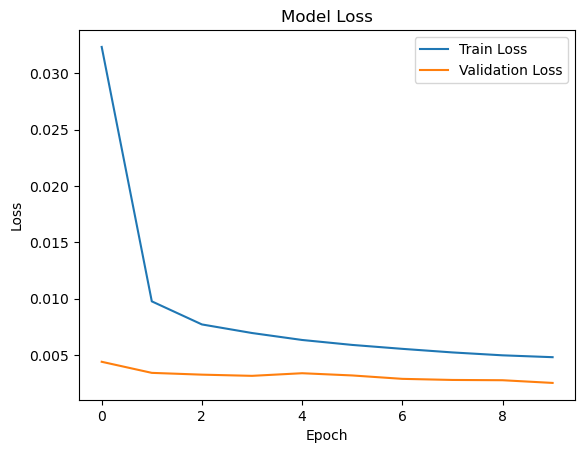

64/64 [==============================] - 1s 11ms/step


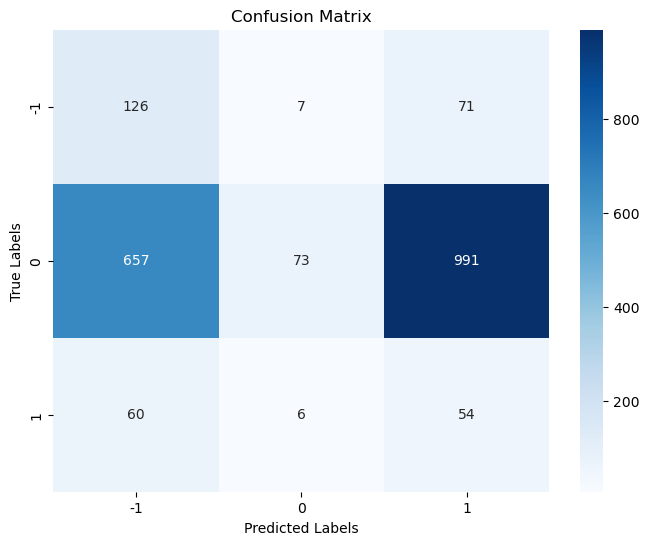

Classification Metrics:
Accuracy: 0.12
Precision: 0.35
Recall: 0.37
F1 Score: 0.14

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.62      0.24       204
           0       0.85      0.04      0.08      1721
           1       0.05      0.45      0.09       120

    accuracy                           0.12      2045
   macro avg       0.35      0.37      0.14      2045
weighted avg       0.73      0.12      0.10      2045

for borrowing rate and BATUSDT
Training data shape: (6132, 48, 5)
Validation data shape: (2045, 48, 5)
Test data shape: (2045, 48, 5)
Training labels shape: (6132, 24, 1)
Validation labels shape: (2045, 24, 1)
Test labels shape: (2045, 24, 1)
Epoch 1/10
62/62 [==============================] - 7s 63ms/step - loss: 0.0113 - mae: 0.0726 - val_loss: 0.0017 - val_mae: 0.0223
Epoch 2/10
62/62 [==============================] - 3s 51ms/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0015 - val_mae: 0.019

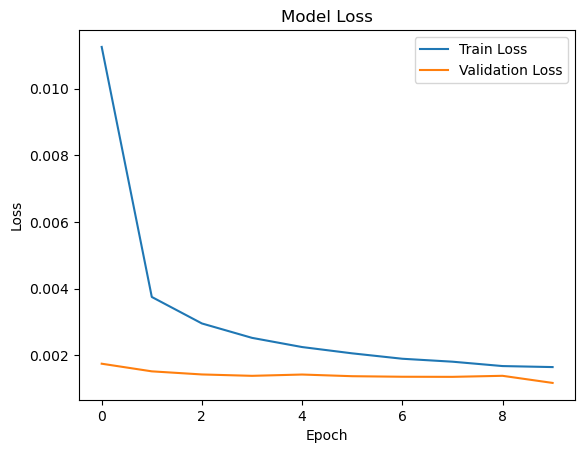

64/64 [==============================] - 1s 10ms/step


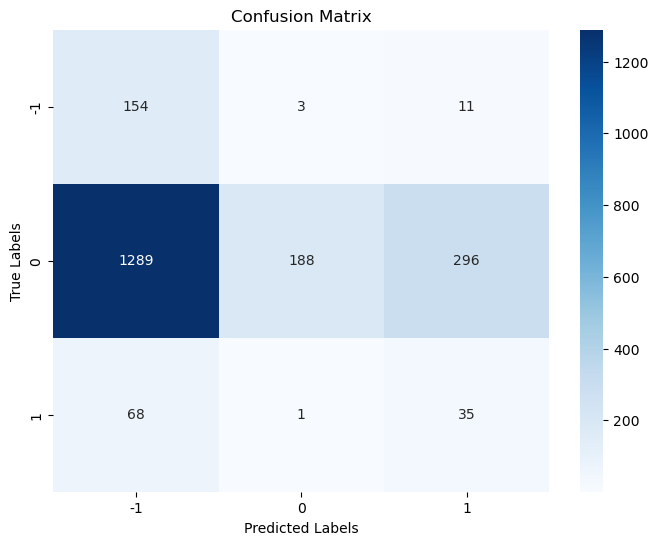

Classification Metrics:
Accuracy: 0.18
Precision: 0.39
Recall: 0.45
F1 Score: 0.18

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.10      0.92      0.18       168
           0       0.98      0.11      0.19      1773
           1       0.10      0.34      0.16       104

    accuracy                           0.18      2045
   macro avg       0.39      0.45      0.18      2045
weighted avg       0.86      0.18      0.19      2045

LINKUSDT 31934
rows with valid returns: 31598
input size (8765, 48, 5)
output size (8765, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and LINKUSDT
Training data shape: (5259, 48, 5)
Validation data shape: (1753, 48, 5)
Test data shape: (1753, 48, 5)
Training labels shape: (5259, 24, 1)
Validation labels shape: (1753, 24, 1)
Test labels shape: (1753, 24, 1)
Epoch 1/10
53/53 [==============================] - 7s 63ms/step - loss: 0.0265 - mae: 0.0996 - val_loss: 0.0

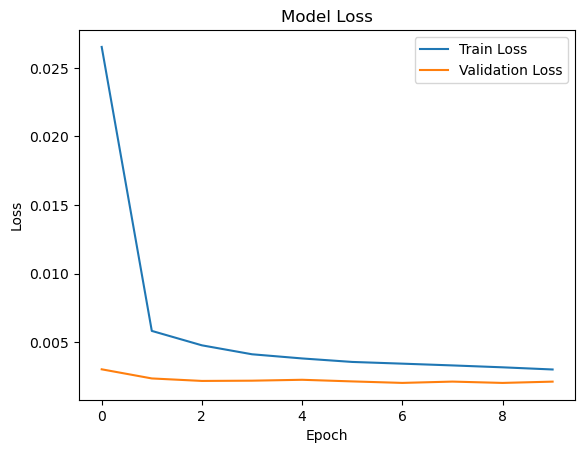

55/55 [==============================] - 1s 10ms/step


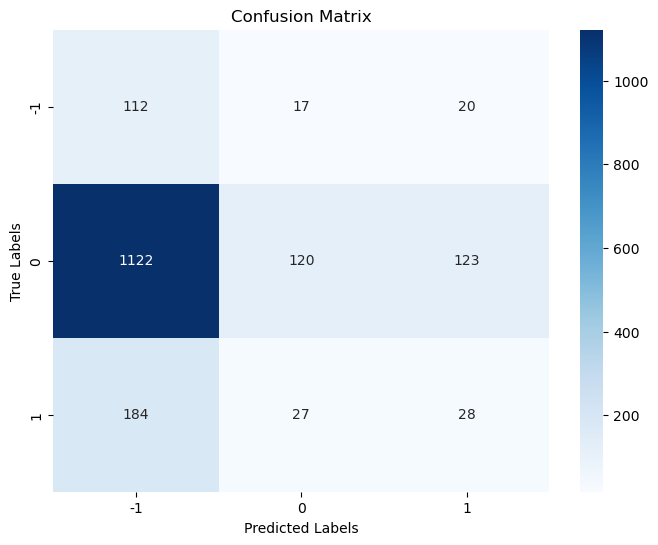

Classification Metrics:
Accuracy: 0.15
Precision: 0.32
Recall: 0.32
F1 Score: 0.15

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.08      0.75      0.14       149
           0       0.73      0.09      0.16      1365
           1       0.16      0.12      0.14       239

    accuracy                           0.15      1753
   macro avg       0.32      0.32      0.15      1753
weighted avg       0.60      0.15      0.15      1753

for borrowing rate and LINKUSDT
Training data shape: (5259, 48, 5)
Validation data shape: (1753, 48, 5)
Test data shape: (1753, 48, 5)
Training labels shape: (5259, 24, 1)
Validation labels shape: (1753, 24, 1)
Test labels shape: (1753, 24, 1)
Epoch 1/10
53/53 [==============================] - 7s 63ms/step - loss: 0.0197 - mae: 0.0901 - val_loss: 0.0013 - val_mae: 0.0237
Epoch 2/10
53/53 [==============================] - 3s 51ms/step - loss: 0.0047 - mae: 0.0429 - val_loss: 7.0907e-04 - val_mae: 

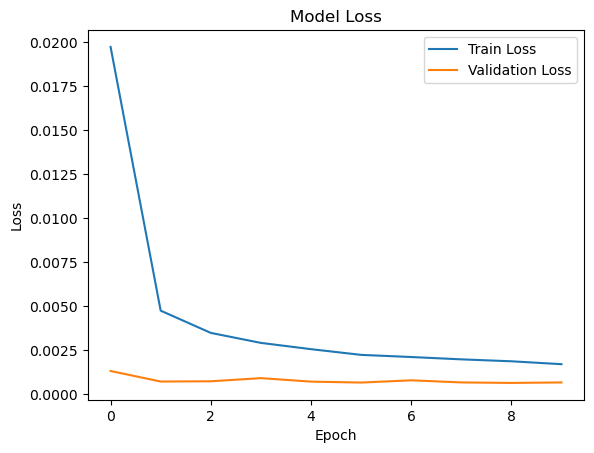

55/55 [==============================] - 1s 11ms/step


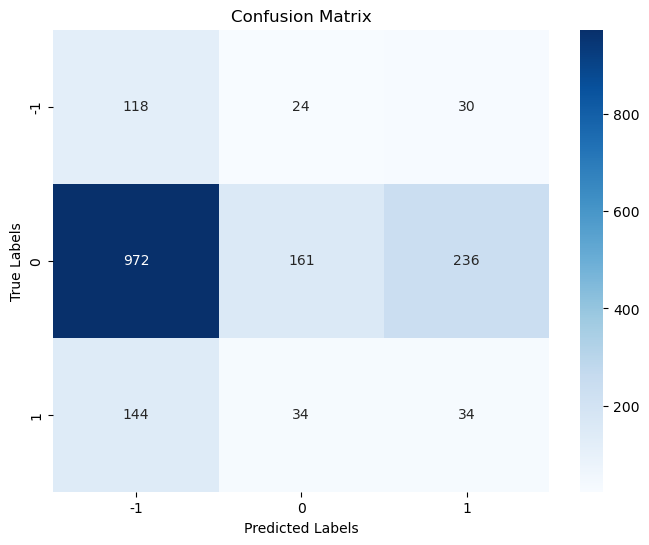

Classification Metrics:
Accuracy: 0.18
Precision: 0.31
Recall: 0.32
F1 Score: 0.17

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.10      0.69      0.17       172
           0       0.74      0.12      0.20      1369
           1       0.11      0.16      0.13       212

    accuracy                           0.18      1753
   macro avg       0.31      0.32      0.17      1753
weighted avg       0.60      0.18      0.19      1753



In [95]:
# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols[0:2]:
     sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
     sim_df.reset_index(inplace=True, drop=True)
     print(s, len(sim_df))
     # First Loop: Calculate intervals for each column without modifying the DataFrame
     intervals = {}
     for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
          lower, upper = pre.calculate_iqr_bounds(sim_df[column])
          intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

     # getting the returns
     reduced_df = sim_df.copy()
     reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
     reduced_df = reduced_df[reduced_df['returns'].notna()]
     print('rows with valid returns:', len(reduced_df))
     reduced_df.reset_index(inplace=True, drop=True)

     # Second Loop: Filter rows based on the pre-calculated intervals
     for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
          lower_bound = intervals[column]['lower_bound']
          upper_bound = intervals[column]['upper_bound']
          # Apply filtering based on pre-calculated bounds
          reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

     reduced_df.reset_index(inplace=True, drop=True)

     # MinMax scaling
     scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

     scaled_df = reduced_df.copy()
     scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
     scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
     scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
     scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
     scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
     scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

     inputs, targets = pre.extract_valid_windows(
          scaled_df,
          'date', 
          48, 24, 
          ['lending_rate',	'borrowing_rate','utilization_rate','returns', 'volume'], 
          ['lending_rate','borrowing_rate']
          )


     print('input size', inputs.shape)
     print('output size', targets.shape)

     # Count NaNs in input and output
     input_nans = np.isnan(inputs).sum()
     output_nans = np.isnan(targets).sum()

     print(f"Number of NaNs in input: {input_nans}")
     print(f"Number of NaNs in output: {output_nans}")

     # lending_rate
     output_1 = targets[:, :, 0].reshape(targets.shape[0], targets.shape[1], 1)  # First column
     # borrowing rate
     output_2 = targets[:, :, 1].reshape(targets.shape[0], targets.shape[1], 1)  # Second column

     print('for lending rate and', s)
     y_test, test_predictions = train_and_evaluate(inputs, output_1)
     growth_data, growth_prediction = rate_growth(y_test, test_predictions)
     classification_metrics(growth_data, growth_prediction)

     print('for borrowing rate and', s)
     y_test, test_predictions = train_and_evaluate(inputs, output_2)
     growth_data, growth_prediction = rate_growth(y_test, test_predictions)
     classification_metrics(growth_data, growth_prediction)

     